In [1]:
# import all we need to compute the mAP and produce some plots
# implementing mAP as documented in The PASCALVisual Object Classes (VOC) Challenge

import numpy as np
import pickle
import os
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import pylab
import math

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [2]:
# grab all computed results 
# (.pkl format from "darknet_evaluation_post_inference.py")

input_path = "C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS"
input_files = []

for file in os.listdir(input_path):
    if file.endswith(".pkl"):
        input_files.append(os.path.join(input_path,file))
        
input_files.sort()
print("Found {} evaluation files.".format(len(input_files)))
for d, dataset in enumerate(input_files):
    print(d, dataset)
    
# use all 20 states of
use_files_real = "rn" # noisy
use_files_synth = "sls" # single large

Found 87 evaluation files.
0 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10001_RESULTS.pkl
1 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10002_RESULTS.pkl
2 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10003_RESULTS.pkl
3 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10004_RESULTS.pkl
4 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs10005_RESULTS.pkl
5 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1001_RESULTS.pkl
6 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1002_RESULTS.pkl
7 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1003_RESULTS.pkl
8 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1004_RESULTS.pkl
9 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs1005_RESULTS.pkl
10 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs101_RESULTS.pkl
11 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs102_RESULTS.pkl
12 C:/Users/Legos/Documents/PhD/FARTS/BENCHMARK/RESULTS\bs103_RESULTS.pkl
13 C:/

In [3]:
with open(input_files[0], 'rb') as f:
    data = pickle.load(f)

"""
- data[0][0]
- training_data_&_training_state

- - data[0][1][0]
- - threshold (for first dataset)
  
- - - data[0][1][1][0 1  2    3   4   5                  6] 
- - - dataset_name,   GT, TP, FN, FP, Average Precision, Recall
"""
#examples:

all_training_states = []

for elem in data:
    all_training_states.append(int(elem[0].split(".")[0].split("_")[-1]))

all_training_states.sort()
print(all_training_states)

[1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 17000, 18000, 19000, 20000]


In [4]:
def clean_dataset_name(file_name,verbose=False):
    """
    return the name of the dataset wihtout the split extension
    """
    base_name = os.path.basename(file_name)
    dataset_name = base_name.split("_")[0][:-1]
    if verbose:
        print(dataset_name)
    return dataset_name

print("Found {} evaluation files.".format(len(input_files)))
    
all_nets_all_APs = []

prev_dataset = clean_dataset_name(input_files[0])
current_AP_group = []
training_datasets = [prev_dataset]


for use_state in range(len(input_files)):
    with open(input_files[use_state], 'rb') as f:
        data = pickle.load(f)

    all_training_states = []

    for elem in data:
        all_training_states.append(int(elem[0].split(".")[0].split("_")[-1]))

    all_training_states.sort()

    final_AP = []
    #print("\n",input_files[use_state])
    
    #all_nets_all_APs.append([input_files[use_state]])
    
    for dataset_idx in range(1,6):
        all_AP = []

        for model in data:
            #print("\nProducing AP plot for {}\n".format(model[0]))
            #print("With dataset {}\n".format(model[1][dataset_idx][0]))
            curve_coords = np.zeros([len(model[1:]),2])
            AP = 0
            R_n = 0
            for e, elem in reversed(list(enumerate(model[1:]))):
                curve_coords[e] = [elem[dataset_idx][6],elem[dataset_idx][5]]
                #print("thresh {}   Precision {}    Recall {}".format(elem[0],round(elem[dataset_idx][5],3),round(elem[dataset_idx][6],3)))
                AP += (elem[dataset_idx][6] - R_n) * elem[dataset_idx][5]
                R_n = elem[dataset_idx][6]

            #plt.plot(curve_coords[:,0],curve_coords[:,1])
            #print("AP: {}\n".format(AP))
            all_AP.append([model[1][dataset_idx][0],int(model[0].split(".")[0].split("_")[-1]),AP])

        #plt.show()

        all_AP.sort()
        #print(all_AP[-1])
        
        # previously, for just the final score: 
        #final_AP.append(all_AP[-1][-1])
        final_AP.append([a[-1] for a in all_AP])

    current_dataset = clean_dataset_name(input_files[use_state])
    if use_state == len(input_files)-1:
        current_AP_group.append(final_AP)
        all_nets_all_APs.append(current_AP_group)
        
    elif current_dataset != prev_dataset:
        prev_dataset = current_dataset
        all_nets_all_APs.append(current_AP_group)
        current_AP_group = []
        training_datasets.append(current_dataset)
        
    else:
        current_AP_group.append(final_AP)
    

Found 87 evaluation files.


In [5]:
for dataset_name, APs in zip(training_datasets,all_nets_all_APs):
    
    if dataset_name == use_files_synth:
        APs = np.array(APs)
        mAPs_synth = np.mean(APs[:,:,:],axis=(0,1))
        s_ind_std = np.std(APs[:,:,:],axis=(0)) # get std for each sub dataset, then (given equal sample sizes) we
                                              # average the variances and take the square root of the result
                                              # using numpy, we can do this in one line of code
        mAPs_synth_std = np.sqrt(np.sum(np.power(s_ind_std,2),axis=0)/s_ind_std.shape[0])
        
    elif dataset_name == use_files_real:
        APs = np.array(APs)
        mAPs_real = np.mean(APs[:,:4,:],axis=(0,1))
        r_ind_std = np.std(APs[:,:4,:],axis=(0)) # exclude training samples (rn: real noisy)
        mAPs_real_std = np.sqrt(np.sum(np.power(r_ind_std,2),axis=0)/r_ind_std.shape[0])
        
print(mAPs_real,"",mAPs_real_std,"\n")
print(mAPs_synth,"",mAPs_synth_std)


[0.86846021 0.88351754 0.91319871 0.85982065 0.90471907 0.8718
 0.88958637 0.90100141 0.8949622  0.87279512 0.86452839 0.85482728
 0.8822957  0.85607789 0.85332205 0.89255793 0.8795898  0.87946788
 0.89948313 0.87841708]  [0.18552892 0.05958948 0.01612834 0.09809721 0.01566396 0.05607995
 0.02247327 0.02584258 0.04867479 0.09068125 0.08090177 0.09663119
 0.03050924 0.08884713 0.09235085 0.01547981 0.06523088 0.04905159
 0.01932661 0.03550145] 

[0.67671034 0.77303646 0.84369469 0.82555893 0.896664   0.89986296
 0.89878621 0.89965754 0.90400016 0.91005885 0.91423246 0.89891757
 0.92763305 0.90784052 0.9003941  0.88937009 0.91484512 0.91695109
 0.91887266 0.91312772]  [0.08837494 0.06187317 0.05595201 0.04621872 0.02006691 0.02281059
 0.01643012 0.03514104 0.01838077 0.03624296 0.0133701  0.03379053
 0.0127609  0.02661496 0.03047461 0.01717573 0.02036126 0.01219729
 0.01196112 0.01063531]


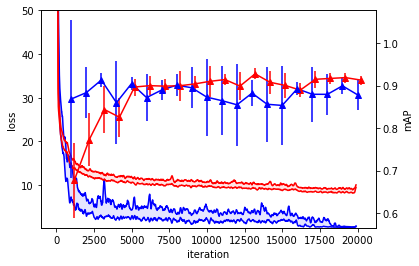

In [6]:
input_files = ["Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_real_lr0001_GPU_72.pbs.o5580934.16",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_real_lr0001_GPU_72.pbs.o5580934.17",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_real_lr0001_GPU_72.pbs.o5580934.18",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_real_lr0001_GPU_72.pbs.o5580934.19",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_real_lr0001_GPU_72.pbs.o5580934.20"]

losses = []
losses_mv_avg = []
mv_avg_samples = 100

for f in input_files:
    loss = []
    in_file = open(f, 'r')
    Lines = in_file.readlines()

    count = 0
    # Strips the newline character
    for line in Lines:
        stripped_line = line.strip().split(" ")
        if len(stripped_line) > 3:
            if stripped_line[3] == "avg":
                loss.append(float(line.strip().split(" ")[2]))
            
    losses.append(loss)
    
losses = np.array(losses)
losses_mv_avg_max = moving_average(x=np.max(losses,axis=0), w=mv_avg_samples)
losses_mv_avg_min = moving_average(x=np.min(losses,axis=0), w=mv_avg_samples)

iterations = np.arange(losses_mv_avg_max.shape[0])

fig, ax = plt.subplots()

ax.plot(iterations,losses_mv_avg_max,color="blue")
ax.plot(iterations,losses_mv_avg_min,color="blue")
ax.fill_between(iterations, (losses_mv_avg_min), (losses_mv_avg_max), color='b', alpha=.1)
#ax.set_yscale('log')
plt.ylim(bottom=0.2, top=100) 
plt.ylabel("loss")
plt.xlabel("iteration")


input_files = ["Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_synth_lr0001_GPU_72.pbs.o5668076.11",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_synth_lr0001_GPU_72.pbs.o5668076.12",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_synth_lr0001_GPU_72.pbs.o5668076.13",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_synth_lr0001_GPU_72.pbs.o5668076.14",
               "Z:/home/FARTS/BENCHMARK/NEW_BATCH_LR_0001/darknet_array_synth_lr0001_GPU_72.pbs.o5668076.15"]

losses = []
losses_mv_avg = []

for f in input_files:
    loss = []
    in_file = open(f, 'r')
    Lines = in_file.readlines()

    count = 0
    # Strips the newline character
    for line in Lines:
        stripped_line = line.strip().split(" ")
        if len(stripped_line) > 3:
            if stripped_line[3] == "avg":
                loss.append(float(line.strip().split(" ")[2]))
            
    losses.append(loss)
    
losses = np.array(losses)
losses_mv_avg_max = moving_average(x=np.max(losses,axis=0), w=mv_avg_samples)
losses_mv_avg_min = moving_average(x=np.min(losses,axis=0), w=mv_avg_samples)

ax.plot(iterations,losses_mv_avg_max,color="red")
ax.plot(iterations,losses_mv_avg_min,color="red")
ax.fill_between(iterations, (losses_mv_avg_min), (losses_mv_avg_max), color='r', alpha=.1)
#ax.set_yscale('log')
plt.ylim(bottom=0.2, top=50) 
plt.ylabel("loss")
plt.xlabel("iteration")


ax2 = ax.twinx()

# shift one of the two mAP axis by 200 iterations to the right so both error bars can be seen
shifted_states = np.array(all_training_states) + 200

ax2.plot(all_training_states,mAPs_real, 'b-')
ax2.plot(shifted_states,mAPs_synth, 'r-')

ax2.errorbar(shifted_states, mAPs_synth, mAPs_synth_std, linestyle='None', marker='^', color='red')
ax2.errorbar(all_training_states, mAPs_real, mAPs_real_std, linestyle='None', marker='^', color='blue') #, capsize=3)

ax2.set_ylabel('mAP')

plt.savefig("mAP_rn_blue_VS_sls_red.svg")
plt.show()